In [399]:
import numpy as np
from scipy.optimize import minimize
import statistics
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm

###  One dimensional data

In [400]:
np.random.seed(1274)

n = 1000 # size of dataset
M = 70 # mean of the prior
tau2 = 1 # variance of the prior
sigma2 = 100 # variance of the likelihood

mu = np.random.normal(M, np.sqrt(tau2), 1) #prior
X = np.random.normal(mu, np.sqrt(sigma2), n) #likelihood

# Parameters of the true posterior
true_mean = (1/tau2)/(1/tau2 + n/sigma2) * M + np.mean(X) * (n/sigma2)/((1/tau2 + n/sigma2))
true_var = (sigma2*tau2/n)/(tau2 + sigma2/n)

#### Log-joint & Objective function

In [401]:
def log_joint(mu, X, M, tau2, sigma2):
    log_lik = np.sum(norm.logpdf(X[:, None], loc=mu, scale=np.sqrt(sigma2)), axis=0)
    log_prior = norm.logpdf(mu, loc=M, scale=np.sqrt(tau2))
    
    return log_lik + log_prior

def objective_function(eta, X, M, tau2, true_var, Z): # negative ELBO
    std = np.sqrt(true_var)
    mu_samples = eta + Z * std

    log_lik = log_joint(mu_samples, X, M, tau2, true_var)
    log_joint_mean = np.mean(log_lik)
    
    objective = - np.log(std) - log_joint_mean

    return objective

#### ADVI 

In [402]:
def finite_diff_gradient(param, X, M, tau2, true_var, Z, delta=1e-5): #approximation of the gradient of our objective function
    grad = 0
    
    param_plus = param + delta
    param_minus = param - delta
    grad = (objective_function(param_plus, X, M, tau2, true_var, Z) - objective_function(param_minus, X, M, tau2, true_var, Z)) / (2 * delta)
    return grad

In [403]:
def SDG(X, M, tau2, true_var, learning_rate=1e-5, max_iter=10000, epsilon=1e-5):
    param = M
    prev_param = param
    
    for iter_num in range(max_iter):
        Z = np.random.randn(1)
        grad = finite_diff_gradient(param, X, M, tau2, true_var, Z, delta=1e-5)
    
        # Gradient descent update
        param -= learning_rate * grad
        
        # Convergence criteria
        if np.linalg.norm(param - prev_param) < epsilon:
            print(f"Converged at iteration {iter_num + 1}")
            break
        
        prev_param = param
        
    return param, iter_num + 1

In [404]:
mean_advi, n_iter = SDG(X, M, tau2, true_var, learning_rate=1e-5, max_iter=10000, epsilon=1e-5)

np.random.seed(5)
Z = np.random.randn(n_iter)
ELBO_ADVI = -objective_function(mean_advi, X, M, tau2, true_var, Z) # Maximum value obtained with ADVI algorithm

print(f"True posterior mean: {true_mean:.3f}")
print(f"ADVI posterior mean: {mean_advi:.3f}")

Converged at iteration 2072
True posterior mean: 70.455
ADVI posterior mean: 70.648


#### DADVI

In [405]:
initial_params = M
result = minimize(objective_function, initial_params, args=(X, M, tau2, true_var, Z), method='L-BFGS-B') 
mean_dadvi = result.x[0]
ELBO_DADVI = -objective_function(mean_dadvi, X, M, tau2, true_var, Z) # Maximum value obtained with DADVI algorithm

print(f"True posterior mean: {true_mean:.3f}")
print(f"DADVI posterior mean: {mean_dadvi:.3f}")

True posterior mean: 70.455
DADVI posterior mean: 70.499


#### Comparison of the objective function 

In [406]:
print(f"ELBO ADVI: {ELBO_ADVI:.3f}")
print(f"ELBO DADVI: {ELBO_DADVI:.3f}")

ELBO ADVI: -563407.332
ELBO DADVI: -563284.620


#### Visualisation

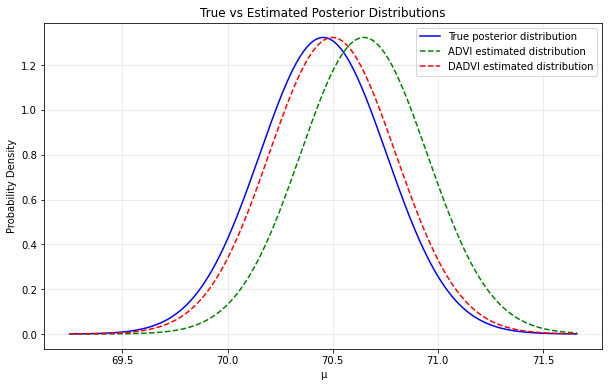

In [407]:
x_range = np.linspace(true_mean - 4*np.sqrt(true_var), true_mean + 4*np.sqrt(true_var), 1000)

true_pdf = stats.norm.pdf(x_range, true_mean, np.sqrt(true_var))
estimated_pdf_advi = stats.norm.pdf(x_range, mean_advi, np.sqrt(true_var))
estimated_pdf_dadvi = stats.norm.pdf(x_range, mean_dadvi, np.sqrt(true_var))

plt.figure(figsize=(10, 6))
plt.plot(x_range, true_pdf, label='True posterior distribution', color='blue')
plt.plot(x_range, estimated_pdf_advi, label='ADVI estimated distribution', color='green', linestyle='--')
plt.plot(x_range, estimated_pdf_dadvi, label='DADVI estimated distribution', color='red', linestyle='--')

plt.title('True vs Estimated Posterior Distributions')
plt.xlabel('μ')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

### One dimension case: Unknown mean and variance

#### Log-joint and Objective function 

In [408]:
def log_joint(mu, X, M, tau2, sigma2):
    n = len(X)
    diff = mu[:, None] - X[None, :]
    
    log_x_mu = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(diff ** 2, axis=1)
    log_mu = -0.5 * np.log(2 * np.pi * tau2) - 0.5 * ((mu - M) ** 2) / tau2

    return log_x_mu + log_mu


def objective_function(params, X, M, sigma2, tau2, Z): #negative elbo
    eta_1, log_std = params
    std = np.exp(log_std)
    
    mu_samples = eta_1 + Z * std

    log_joints = log_joint(mu_samples, X, M, tau2, sigma2)
    log_joint_mean = np.mean(log_joints)
    
    objective = -log_std - log_joint_mean
    return objective

#### ADVI

In [409]:
def gradient_with_npgradient(
    func,           # function of a 2D param vector: func([eta_1, log_eta_2]) -> float
    theta,          # current parameters, shape (2,)
    delta=1e-5,     # spacing for the grid
    grid_size=3     # e.g. a 3x3 or 5x5 grid
):
    """
    Approximate grad func(theta) using np.gradient on a small 2D grid.

    - theta = [eta_1, log_eta_2]
    - We'll produce a (grid_size x grid_size) array of function values
      around the point (eta_1, log_eta_2).
    - Then we'll call np.gradient(F) to approximate partial derivatives.
    - We'll return [dF/d(eta_1), dF/d(log_eta_2)] at the center.
    """
    K = grid_size
    half = K // 2  # center index
    # Build param arrays in each dimension
    param0_vals = theta[0] + (np.arange(K) - half)*delta
    param1_vals = theta[1] + (np.arange(K) - half)*delta

    # Evaluate the function on this 2D grid
    F = np.zeros((K, K), dtype=float)
    for i, val0 in enumerate(param0_vals):
        for j, val1 in enumerate(param1_vals):
            pvec = np.array([val0, val1])
            F[i, j] = func(pvec)

    # Use np.gradient to approximate partial derivatives along each axis
    # dF_d0 has shape (K, K), derivative w.r.t. axis 0 (param0_vals)
    # dF_d1 has shape (K, K), derivative w.r.t. axis 1 (param1_vals)
    dF_d0, dF_d1 = np.gradient(F, delta, delta)

    # The gradient at the center index
    grad0 = dF_d0[half, half]
    grad1 = dF_d1[half, half]
    return np.array([grad0, grad1])

In [410]:
def SDG(X, sigma2, M, tau2, learning_rate=1e-5, max_iter=10000, epsilon=1e-5):
    eta_1 = M  # Initialisation at the prior's mean
    log_std = np.log(np.sqrt(tau2))  # Initialisation at the prior's log standard deviation
    #log_std = np.log(np.sqrt(0.048))  # Initialisation at the prior's log standard deviation

    prev_params = np.array([eta_1, log_std])
    params = np.array([eta_1, log_std])

    for iter_num in range(max_iter):
        Z = np.random.randn(1)  
        def local_objective(prm, Z): # to fix the sample during the approximation of the gradient
            return objective_function(prm, X, M, sigma2, tau2, Z)

        grad = gradient_with_npgradient(func=lambda prm: local_objective(prm, Z), theta=params, delta=1e-5, grid_size=3)
        
        #Gradient descent update
        params -= learning_rate * grad

        # Convergence criteria
        if np.linalg.norm(params - prev_params) ** 2 < epsilon and iter_num>5:
            print(f"Converged at iteration {iter_num + 1}.")
            break
        prev_params = np.copy(params)

    eta_1_opt = params[0]
    eta_2_opt = np.exp(2 *params[1])
    return eta_1_opt, eta_2_opt, iter_num + 1

In [411]:
mean_advi, var_advi, n_iter = SDG(X, sigma2, M, tau2, learning_rate=1e-5, max_iter=10000, epsilon=1e-5)

np.random.seed(17)
Z = np.random.randn(n_iter)  
ELBO_ADVI = - objective_function([mean_advi, np.log(np.sqrt(var_advi))], X, M, sigma2, tau2, Z) # Maximum value obtained with ADVI algorithm

print(f"True posterior mean: {true_mean:.3f}, True posterior variance: {true_var:.3f}")
print(f"ADVI posterior mean: {mean_advi:.3f}, ADVI posterior variance: {var_advi:.3f}")

Converged at iteration 7.
True posterior mean: 70.455, True posterior variance: 0.091
ADVI posterior mean: 70.000, ADVI posterior variance: 0.998


#### DADVI

In [412]:
initial_params = (M, np.log(np.sqrt(tau2)))

result = minimize(objective_function, initial_params, args=(X, M, sigma2, tau2, Z), method='L-BFGS-B')

optimized_eta_1, optimized_log_std = result.x
optimized_var = np.exp(2 * optimized_log_std)

mean_dadvi = optimized_eta_1
var_dadvi = optimized_var

ELBO_DADVI = - objective_function([mean_dadvi, np.log(np.sqrt(var_dadvi))], X, M, sigma2, tau2, Z) # Maximum value obtained with DADVI algorithm

print(f"True posterior mean: {true_mean:.3f}, True posterior variance: {true_var:.3f}")
print(f"DADVI posterior mean: {mean_dadvi:.3f}, DADVI posterior variance: {var_dadvi:.3f}")

True posterior mean: 70.455, True posterior variance: 0.091
DADVI posterior mean: 70.338, DADVI posterior variance: 0.074


#### Comparison of the objective function value

In [413]:
print(f"ELBO ADVI: {ELBO_ADVI:.3f}")
print(f"ELBO DADVI: {ELBO_DADVI:.3f}")

ELBO ADVI: -3741.165
ELBO DADVI: -3736.235


#### Visualisation

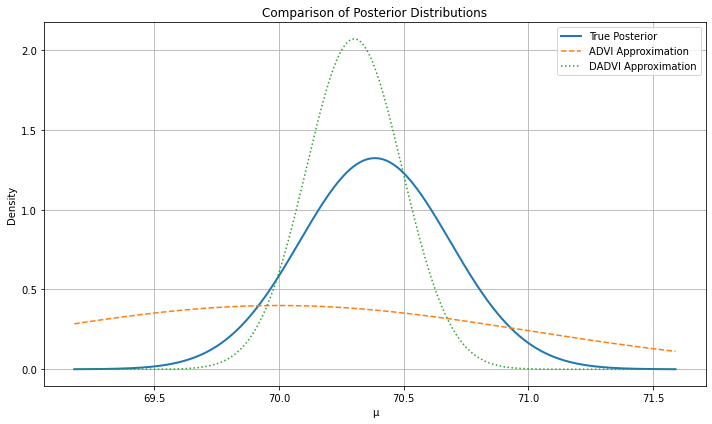

In [221]:
x = np.linspace(true_mean - 4 * np.sqrt(true_var), true_mean + 4 * np.sqrt(true_var), 1000)

true_posterior = norm.pdf(x, true_mean, np.sqrt(true_var))
advi_posterior = norm.pdf(x, mean_advi, np.sqrt(var_advi))
dadvi_posterior = norm.pdf(x, mean_dadvi, np.sqrt(var_dadvi))

plt.figure(figsize=(10, 6))
plt.plot(x, true_posterior, label='True Posterior', linewidth=2)
plt.plot(x, advi_posterior, label='ADVI Approximation', linestyle='--')
plt.plot(x, dadvi_posterior, label='DADVI Approximation', linestyle=':')
plt.title("Comparison of Posterior Distributions")
plt.xlabel("μ")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Two dimensional data 

#### Independent with same variance

#### Data generation 

In [285]:
np.random.seed(4502)

M = np.array([20, 30]) # Prior mean
tau2 = 1 # Prior variance
sigma2 = 100 # Variance
n = 1000 # Sample size
d = len(M) 

mu = np.random.multivariate_normal(M, tau2 * np.eye(d)) # prior
true_cov = sigma2 * np.eye(d)
data = np.random.multivariate_normal(mu, true_cov, size=n) # likelihood

# Parameters of the true posterior
true_mean = (M + np.sum(data, axis=0)/sigma2)*(1 / (1/tau2 + n/sigma2))
true_var= 1/(1+ n/sigma2)

#### Log-joint and Objective function 

In [286]:
def log_joint(mu_samples, data, M, tau2, sigma2):
    N, d = mu_samples.shape
    n = data.shape[0]

    diff = data[None, :, :] - mu_samples[:, None, :]
    sq_norms = np.sum(diff ** 2, axis=2) 
    log_x_mu = -0.5 * n * d * np.log(2 * np.pi * sigma2) - 0.5 * np.sum(sq_norms, axis=1) / sigma2

    prior_diff = mu_samples - M
    log_mu = -0.5 * d * np.log(2 * np.pi * tau2) - 0.5 * np.sum(prior_diff ** 2, axis=1) / tau2

    return log_x_mu + log_mu


def objective_function(params, data, M, tau2, sigma2, Z):  # negative ELBO
    d = len(M)
    eta_1 = np.array(params[:d])  
    log_std = np.array(params[d:]) 
    std = np.exp(log_std)

    mu_samples = eta_1 + Z * std 

    log_joints = log_joint(mu_samples, data, M, tau2, sigma2)
    log_joint_mean = np.mean(log_joints)

    negative_elbo = -log_joint_mean - np.sum(log_std)
    return negative_elbo

#### ADVI

In [287]:
def gradient_with_npgradient_nd(func, theta, delta=1e-5, grid_size=3):
    d = len(theta)
    K = grid_size
    half = K // 2
    
    param_vals = [theta[i] + (np.arange(K) - half) * delta for i in range(d)]

    mesh = np.meshgrid(*param_vals, indexing='ij')
    
    F = np.zeros(mesh[0].shape)
    
    it = np.nditer(F, flags=['multi_index'])
    while not it.finished:
        index = it.multi_index
        point = np.array([mesh[dim][index] for dim in range(d)])
        F[index] = func(point)
        it.iternext()

    grads = np.gradient(F, delta)

    center_idx = tuple([half] * d)
    grad = np.array([grads[dim][center_idx] for dim in range(d)])

    return grad

In [288]:
def SDG(X, sigma2, M, tau2, learning_rate, max_iter=10000, epsilon=10-5):
    d = len(M)
    
    eta_1 = M
    eta_2 = np.log(np.sqrt(tau2)) 
    
    params = np.concatenate([eta_1, [eta_2]])  
    prev_params = params.copy()

    for iter_num in range(max_iter):
        Z = np.random.randn(1, d)

        def local_objective(prm): # to fix the sample Z during the estimation of gradient
            return objective_function(prm, data, M, tau2, sigma2, Z)
        grad = gradient_with_npgradient_nd(func=local_objective, theta=params, delta=1e-5, grid_size=3)
        
        # Gradient descent update
        params -= learning_rate * grad

        # Cnverge criteria
        if np.linalg.norm(params - prev_params) < epsilon:
            print(f"Converged at iteration {iter_num + 1}.")
            break

        prev_params = params.copy()

    eta_1_opt = params[:d]
    eta_2_opt = np.exp(2*params[d:])

    return eta_1_opt, eta_2_opt, iter_num + 1

In [289]:
mean_advi, var_advi, n_iter = SDG(data, sigma2, M, tau2, learning_rate=1e-3, max_iter=10000, epsilon=1e-5)

np.random.seed(56)
Z = np.random.randn(n_iter, len(M))
ELBO_ADVI = - objective_function(np.concatenate([mean_advi, np.log(np.sqrt(var_advi))]), data, M, sigma2, tau2, Z) # Maximum value obtained with ADVI algorithm

print(f"ADVI posterior mean 1: {mean_advi[0]:.3f}, ADVI posterior mean 2: {mean_advi[1]:.3f}, ADVI variance: {var_advi[0]:.3f}")
print(f"True posterior mean 1: {true_mean[0]:.3f}, True posterior mean 2: {true_mean[1]:.3f}, True posterior variance: {true_var:.3f}")

ADVI posterior mean 1: 20.242, ADVI posterior mean 2: 30.418, ADVI variance: 0.045
True posterior mean 1: 20.235, True posterior mean 2: 30.415, True posterior variance: 0.091


#### DADVI

In [290]:
initial_params = np.append(M, np.log(np.sqrt(tau2)))

result = minimize(objective_function, initial_params, args=(data, M, tau2, sigma2, Z), method="L-BFGS-B")
mean_dadvi = result.x[:2]
var_dadvi = np.exp(2*result.x[2])

ELBO_DADVI = - objective_function(np.concatenate([mean_dadvi, np.full_like(mean_dadvi, np.log(np.sqrt(var_dadvi)))]), data, M, sigma2, tau2, Z) # Maximum value obtained with DADVI algorithm

print(f"DADVI posterior mean 1: {mean_dadvi[0]:.3f}, DADVI posterior mean 2: {mean_dadvi[1]:.3f}, DADVI variance: {var_dadvi:.3f}")
print(f"True posterior mean 1: {true_mean[0]:.3f}, True posterior mean 2: {true_mean[1]:.3f}, True posterior variance: {true_var:.3f}")

DADVI posterior mean 1: 20.233, DADVI posterior mean 2: 30.416, DADVI variance: 0.045
True posterior mean 1: 20.235, True posterior mean 2: 30.415, True posterior variance: 0.091


#### Comparison of the objective function

In [291]:
print(f"ELBO_ADVI: {ELBO_ADVI:.3f}")
print(f"ELBO_DADVI: {ELBO_DADVI:.3f}")

ELBO_ADVI: -95993.174
ELBO_DADVI: -95995.456


### Independent with different variances

#### Generating data 

In [252]:
np.random.seed(45)

n = 1000 # size of dataset
M = np.array([20, 30]) # mean of the prior
tau2 = 1 # variance of the prior
covariance_matrix = np.array([[25, 0], [0, 50]]) # covariance - variance matrix of the likelihood

mu = np.random.multivariate_normal(M, tau2 * np.eye(2)) # prior
data = np.random.multivariate_normal(mu, covariance_matrix, n) # likelihood

# Parameters of the true posterior
true_var = np.linalg.inv((1/tau2) * np.eye(2) + len(data) * np.linalg.inv(covariance_matrix))
true_mean = true_var @ (M + np.sum(data @ np.linalg.inv(covariance_matrix), axis=0))
true_var = true_var.diagonal()

#### Log-joint & objective function

In [253]:
def log_joint(mu, data, M, tau2, covariance_matrix):
    n = len(data)
    d = data.shape[1]

    cov_inv = np.linalg.inv(covariance_matrix)
    diff = data - mu
    square = np.sum(diff @ cov_inv * diff)

    log_x_mu = -0.5 * n * (d * np.log(2 * np.pi) + np.log(np.linalg.det(covariance_matrix))) - 0.5 * square
    log_mu = -0.5 * d * np.log(2 * np.pi * tau2) - 0.5 * np.sum((mu - M) ** 2) / tau2

    return log_x_mu + log_mu


def objective_function(params, data, M, tau2, covariance_matrix, Z):# negative ELBO
    eta_1 = np.array(params[:2])
    log_std = params[2:]
    std = np.exp(log_std)
    var = std ** 2
    transformed_mu = eta_1 + std * Z
    N = len(Z)

    log_joint_mean = np.sum([log_joint(mu, data, M, tau2, covariance_matrix) for mu in transformed_mu]) / N
    objective = -np.sum(log_std) - log_joint_mean
    return objective

#### ADVI 

In [254]:
def SDG(data, covariance_matrix, M, tau2, learning_rate=1e-3, max_iter=10000, epsilon=1e-5):
    d = len(M)

    # Initialisation
    eta_1 = M
    log_std = np.log(np.sqrt(tau2)) * np.ones(d)
    params = np.concatenate([eta_1, log_std])
    prev_params = params.copy()

    for iter_num in range(max_iter):
        Z = np.random.randn(1, d)

        def local_objective(prm): # to fix the sample Z during the approximation of the gradient
            return objective_function(prm, data, M, tau2, covariance_matrix, Z)

        grad = gradient_with_npgradient_nd(func=local_objective, theta=params, delta=1e-5, grid_size=3)
        
        # Gradient descent update
        params -= learning_rate * grad

        # Convergence criteria
        if np.linalg.norm(params - prev_params) < epsilon:
            print(f"Converged at iteration {iter_num + 1}.")
            break

        prev_params = params.copy()

    eta_1_opt = params[:d]
    var_opt = np.exp(2 * params[d:])
    return eta_1_opt, var_opt, iter_num + 1

In [255]:
mean_advi, var_advi, n_iter = SDG(data, covariance_matrix, M, tau2, learning_rate=1e-3, max_iter=10000, epsilon=1e-5)

np.random.seed(10)
Z = np.random.randn(n_iter, len(M))
params_advi = np.concatenate([mean_advi, np.log(np.sqrt(var_advi))])
ELBO_ADVI = - objective_function(params_advi, data, M, tau2, covariance_matrix, Z) # Maximum value obtained with ADVI algorithm

In [256]:
print(f"ADVI posterior mean 1: {mean_advi[0]:.3f}, ADVI posterior mean 2: {mean_advi[1]:.3f}, ADVI variance 1: {var_advi[0]:.3f}, ADVI variance 2: {var_advi[1]:.3f}")
print(f"True posterior mean 1: {true_mean[0]:.3f}, True posterior mean 2: {true_mean[1]:.3f}, True posterior variance 1: {true_var[0]:.3f}, True posterior variance 2: {true_var[1]:.3f}")

ADVI posterior mean 1: 19.812, ADVI posterior mean 2: 30.448, ADVI variance 1: 0.023, ADVI variance 2: 0.054
True posterior mean 1: 19.815, True posterior mean 2: 30.409, True posterior variance 1: 0.024, True posterior variance 2: 0.048


#### DADVI 

In [257]:
d = data.shape[1]
eta_1 = M
log_std = np.log(np.sqrt(tau2)) * np.ones(d)
params_init = np.concatenate([eta_1, log_std])

result = minimize(objective_function, params_init,args=(data, M, tau2, covariance_matrix, Z),method="L-BFGS-B")

In [258]:
mean_dadvi = result.x[:d]
var_dadvi = np.exp(2 * result.x[d:])
params_dadvi = np.concatenate([mean_dadvi, np.log(np.sqrt(var_dadvi))])
ELBO_DADVI = - objective_function(params_dadvi, data, M, tau2, covariance_matrix, Z) # Maximum value obtained with DADVI algorithm

In [259]:
print(f"DADVI posterior mean 1: {mean_dadvi[0]:.3f}, DADVI posterior mean 2: {mean_dadvi[1]:.3f}, DADVI variance 1: {var_dadvi[0]:.3f}, DADVI variance 2: {var_dadvi[1]:.3f}")
print(f"True posterior mean 1: {true_mean[0]:.3f}, True posterior mean 2: {true_mean[1]:.3f}, True posterior variance 1: {true_var[0]:.3f}, True posterior variance 2: {true_var[1]:.3f}")

DADVI posterior mean 1: 19.815, DADVI posterior mean 2: 30.409, DADVI variance 1: 0.024, DADVI variance 2: 0.048
True posterior mean 1: 19.815, True posterior mean 2: 30.409, True posterior variance 1: 0.024, True posterior variance 2: 0.048


#### Comparison of the objective function 

In [57]:
print(f"ELBO_ADVI: {ELBO_ADVI:.3f}")
print(f"ELBO_DADVI: {ELBO_DADVI:.3f}")

ELBO_ADVI: -6371.450
ELBO_DADVI: -6371.444
